<a href="https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/beta/AlphaFold2_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AlphaFold2_advanced

-----------------
- <b><font color='green'>21Aug2021: MMseqs2 API has finished upgrade, all should be ready to go! Report any errors.</font></b>

-----------------

This notebook modifies deepmind's [original notebook](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) to add experimental support for modeling complexes (both homo and hetero-oligomers), option to run MMseqs2 instead of Jackhmmer for MSA generation and advanced functionality.

See [ColabFold](https://github.com/sokrypton/ColabFold/) for other related notebooks

**Limitations**
- This notebook does NOT use Templates.
- For a typical Google-Colab session, with a `16G-GPU`, the max total length is **1400 residues**. Sometimes a `12G-GPU` is assigned, in which the max length is ~1000 residues.
- Can I use the models for **Molecular Replacement**? Yes, but be CAREFUL, the bfactor column is populated with pLDDT confidence values (higher = better). Phenix.phaser expects a "real" bfactor, where (lower = better). See [post](https://twitter.com/cheshireminima/status/1423929241675120643) from Claudia Millán on how to process models.

In [1]:
#@title Install software
#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left.

import os
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

import jax
if jax.local_devices()[0].platform == 'tpu':
  raise RuntimeError('Colab TPU runtime not supported. Change it to GPU via Runtime -> Change Runtime Type -> Hardware accelerator -> GPU.')
elif jax.local_devices()[0].platform == 'cpu':
  raise RuntimeError('Colab CPU runtime not supported. Change it to GPU via Runtime -> Change Runtime Type -> Hardware accelerator -> GPU.')

from IPython.utils import io
import subprocess
import tqdm.notebook

GIT_REPO = 'https://github.com/deepmind/alphafold'
SOURCE_URL = 'https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar'
PARAMS_DIR = './alphafold/data/params'
PARAMS_PATH = os.path.join(PARAMS_DIR, os.path.basename(SOURCE_URL))
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'


########################################################################################
# --- Python imports ---
import colabfold as cf
import pairmsa
import sys
import pickle

if "/content/tmp/bin" not in os.environ['PATH']:
  os.environ['PATH'] += ":/content/tmp/bin:/content/tmp/scripts"
if "/content/tmp/mmseqs/bin" not in os.environ['PATH']:
  os.environ['PATH'] += ":/content/tmp/mmseqs/bin"

from urllib import request
from concurrent import futures
#from google.colab import files
import json
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import py3Dmol

from alphafold.model import model
from alphafold.model import config
from alphafold.model import data

from alphafold.data import parsers
from alphafold.data import pipeline
from alphafold.data.tools import jackhmmer

from alphafold.common import protein

def run_jackhmmer(sequence, prefix):

  fasta_path = f"{prefix}.fasta"
  with open(fasta_path, 'wt') as f:
    f.write(f'>query\n{sequence}')

  pickled_msa_path = f"{prefix}.jackhmmer.pickle"
  if os.path.isfile(pickled_msa_path):
    msas_dict = pickle.load(open(pickled_msa_path,"rb"))
    msas, deletion_matrices, names = (msas_dict[k] for k in ['msas', 'deletion_matrices', 'names'])
    full_msa = []
    for msa in msas:
      full_msa += msa
  else:
    # --- Find the closest source ---
    test_url_pattern = 'https://storage.googleapis.com/alphafold-colab{:s}/latest/uniref90_2021_03.fasta.1'
    ex = futures.ThreadPoolExecutor(3)
    def fetch(source):
      request.urlretrieve(test_url_pattern.format(source))
      return source
    fs = [ex.submit(fetch, source) for source in ['', '-europe', '-asia']]
    source = None
    for f in futures.as_completed(fs):
      source = f.result()
      ex.shutdown()
      break

    jackhmmer_binary_path = '/usr/bin/jackhmmer'
    dbs = []

    num_jackhmmer_chunks = {'uniref90': 59, 'smallbfd': 17, 'mgnify': 71}
    total_jackhmmer_chunks = sum(num_jackhmmer_chunks.values())
    with tqdm.notebook.tqdm(total=total_jackhmmer_chunks, bar_format=TQDM_BAR_FORMAT) as pbar:
      def jackhmmer_chunk_callback(i):
        pbar.update(n=1)

      pbar.set_description('Searching uniref90')
      jackhmmer_uniref90_runner = jackhmmer.Jackhmmer(
          binary_path=jackhmmer_binary_path,
          database_path=f'https://storage.googleapis.com/alphafold-colab{source}/latest/uniref90_2021_03.fasta',
          get_tblout=True,
          num_streamed_chunks=num_jackhmmer_chunks['uniref90'],
          streaming_callback=jackhmmer_chunk_callback,
          z_value=135301051)
      dbs.append(('uniref90', jackhmmer_uniref90_runner.query(fasta_path)))

      pbar.set_description('Searching smallbfd')
      jackhmmer_smallbfd_runner = jackhmmer.Jackhmmer(
          binary_path=jackhmmer_binary_path,
          database_path=f'https://storage.googleapis.com/alphafold-colab{source}/latest/bfd-first_non_consensus_sequences.fasta',
          get_tblout=True,
          num_streamed_chunks=num_jackhmmer_chunks['smallbfd'],
          streaming_callback=jackhmmer_chunk_callback,
          z_value=65984053)
      dbs.append(('smallbfd', jackhmmer_smallbfd_runner.query(fasta_path)))

      pbar.set_description('Searching mgnify')
      jackhmmer_mgnify_runner = jackhmmer.Jackhmmer(
          binary_path=jackhmmer_binary_path,
          database_path=f'https://storage.googleapis.com/alphafold-colab{source}/latest/mgy_clusters_2019_05.fasta',
          get_tblout=True,
          num_streamed_chunks=num_jackhmmer_chunks['mgnify'],
          streaming_callback=jackhmmer_chunk_callback,
          z_value=304820129)
      dbs.append(('mgnify', jackhmmer_mgnify_runner.query(fasta_path)))

    # --- Extract the MSAs and visualize ---
    # Extract the MSAs from the Stockholm files.
    # NB: deduplication happens later in pipeline.make_msa_features.

    mgnify_max_hits = 501
    msas = []
    deletion_matrices = []
    names = []
    for db_name, db_results in dbs:
      unsorted_results = []
      for i, result in enumerate(db_results):
        msa, deletion_matrix, target_names = parsers.parse_stockholm(result['sto'])
        e_values_dict = parsers.parse_e_values_from_tblout(result['tbl'])
        e_values = [e_values_dict[t.split('/')[0]] for t in target_names]
        zipped_results = zip(msa, deletion_matrix, target_names, e_values)
        if i != 0:
          # Only take query from the first chunk
          zipped_results = [x for x in zipped_results if x[2] != 'query']
        unsorted_results.extend(zipped_results)
      sorted_by_evalue = sorted(unsorted_results, key=lambda x: x[3])
      db_msas, db_deletion_matrices, db_names, _ = zip(*sorted_by_evalue)
      if db_msas:
        if db_name == 'mgnify':
          db_msas = db_msas[:mgnify_max_hits]
          db_deletion_matrices = db_deletion_matrices[:mgnify_max_hits]
          db_names = db_names[:mgnify_max_hits]
        msas.append(db_msas)
        deletion_matrices.append(db_deletion_matrices)
        names.append(db_names)
        msa_size = len(set(db_msas))
        print(f'{msa_size} Sequences Found in {db_name}')

      pickle.dump({"msas":msas,
                   "deletion_matrices":deletion_matrices,
                   "names":names}, open(pickled_msa_path,"wb"))
  return msas, deletion_matrices, names

In [2]:
#@title Enter the amino acid sequence to fold ⬇️
import re

# define sequence
sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK' #@param {type:"string"}
sequence = re.sub("[^A-Z:/]", "", sequence.upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("/+","/",sequence)

jobname = "test" #@param {type:"string"}
jobname = re.sub(r'\W+', '', jobname)

# define number of copies
homooligomer =  "1" #@param {type:"string"}
homooligomer = re.sub("[:/]+",":",homooligomer)
if len(homooligomer) == 0: homooligomer = "1"
homooligomer = re.sub("[^0-9:]", "", homooligomer)
homooligomers = [int(h) for h in homooligomer.split(":")]

#@markdown - `sequence` Specify protein sequence to be modelled.
#@markdown  - Use `/` to specify intra-protein chainbreaks (for trimming regions within protein).
#@markdown  - Use `:` to specify inter-protein chainbreaks (for modeling protein-protein hetero-complexes).
#@markdown  - For example, sequence `AC/DE:FGH` will be modelled as polypeptides: `AC`, `DE` and `FGH`. A seperate MSA will be generates for `ACDE` and `FGH`.
#@markdown    If `pair_msa` is enabled, `ACDE`'s MSA will be paired with `FGH`'s MSA.
#@markdown - `homooligomer` Define number of copies in a homo-oligomeric assembly.
#@markdown  - Use `:` to specify different homooligomeric state (copy numer) for each component of the complex. 
#@markdown  - For example, **sequence:**`ABC:DEF`, **homooligomer:** `2:1`, the first protein `ABC` will be modeled as a homodimer (2 copies) and second `DEF` a monomer (1 copy).

ori_sequence = sequence
sequence = sequence.replace("/","").replace(":","")
seqs = ori_sequence.replace("/","").split(":")

if len(seqs) != len(homooligomers):
  if len(homooligomers) == 1:
    homooligomers = [homooligomers[0]] * len(seqs)
    homooligomer = ":".join([str(h) for h in homooligomers])
  else:
    while len(seqs) > len(homooligomers):
      homooligomers.append(1)
    homooligomers = homooligomers[:len(seqs)]
    homooligomer = ":".join([str(h) for h in homooligomers])
    print("WARNING: Mismatch between number of breaks ':' in 'sequence' and 'homooligomer' definition")

full_sequence = "".join([s*h for s,h in zip(seqs,homooligomers)])

# prediction directory
output_dir = 'prediction_' + jobname + '_' + cf.get_hash(full_sequence)[:5]
os.makedirs(output_dir, exist_ok=True)
# delete existing files in working directory
for f in os.listdir(output_dir):
  os.remove(os.path.join(output_dir, f))

MIN_SEQUENCE_LENGTH = 16
MAX_SEQUENCE_LENGTH = 2500

aatypes = set('ACDEFGHIKLMNPQRSTVWY')  # 20 standard aatypes
if not set(full_sequence).issubset(aatypes):
  raise Exception(f'Input sequence contains non-amino acid letters: {set(sequence) - aatypes}. AlphaFold only supports 20 standard amino acids as inputs.')
if len(full_sequence) < MIN_SEQUENCE_LENGTH:
  raise Exception(f'Input sequence is too short: {len(full_sequence)} amino acids, while the minimum is {MIN_SEQUENCE_LENGTH}')
if len(full_sequence) > MAX_SEQUENCE_LENGTH:
  raise Exception(f'Input sequence is too long: {len(full_sequence)} amino acids, while the maximum is {MAX_SEQUENCE_LENGTH}. Please use the full AlphaFold system for long sequences.')

if len(full_sequence) > 1400:
  print(f"WARNING: For a typical Google-Colab-GPU (16G) session, the max total length is ~1400 residues. You are at {len(full_sequence)}! Run Alphafold may crash.")

print(f"homooligomer: '{homooligomer}'")
print(f"total_length: '{len(full_sequence)}'")
print(f"working_directory: '{output_dir}'")


homooligomer: '1'
total_length: '59'
working_directory: 'prediction_test_a5e17'


running mmseqs2
7885 Sequences Found in Total


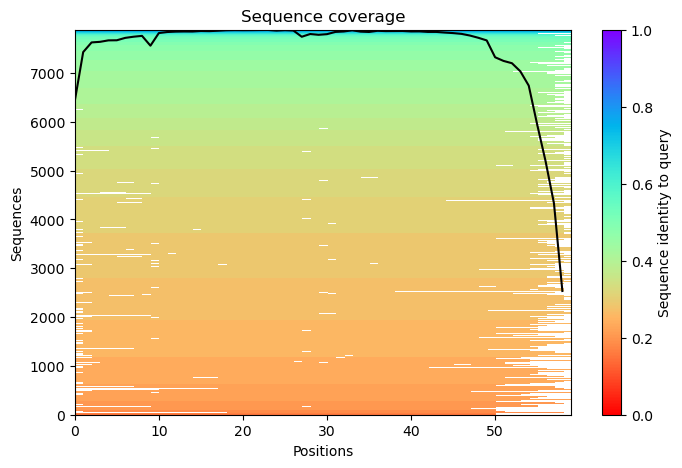

In [3]:
#@title Search against genetic databases
#@markdown Once this cell has been executed, you will see
#@markdown statistics about the multiple sequence alignment 
#@markdown (MSA) that will be used by AlphaFold. In particular, 
#@markdown you’ll see how well each residue is covered by similar 
#@markdown sequences in the MSA.
#@markdown (Note that the search against databases and the actual prediction can take some time, from minutes to hours, depending on the length of the protein and what type of GPU you are allocated by Colab.)

#@markdown ---
msa_method = "mmseqs2" #@param ["mmseqs2","jackhmmer","single_sequence","precomputed"]
#@markdown - `mmseqs2` - FAST method from [ColabFold](https://github.com/sokrypton/ColabFold)
#@markdown - `jackhmmer` - default method from Deepmind (SLOW, but may find more/less sequences).
#@markdown - `single_sequence` - use single sequence input
#@markdown - `precomputed` If you have previously run this notebook and saved the results,
#@markdown you can skip this step by uploading 
#@markdown the previously generated  `prediction_?????/msa.pickle`
#@markdown ---
#@markdown Pair msa options (for protein-protein interaction)
pair_msa = False #@param {type:"boolean"}
pair_cov = 50 #@param [50,75,90] {type:"raw"}
pair_qid = 20 #@param [15,20,30,40,50] {type:"raw"}
include_unpaired_msa = True #@param {type:"boolean"}
#@markdown - `pair_msa` experimental option, that attempts to pair sequences from the same operon within the genome. 
#@markdown (Note: Will only help for prokaryotic protein complexes). Might FAIL if any paralogs in the complex.
#@markdown  - `pair_cov` minimum coverage with query (%)
#@markdown  - `pair_qid` minimum sequence identity with query (%)
#@markdown  - `include_unpaired_msa` disabling may help if there are enough paired sequences.
#@markdown ---

add_custom_msa = False #@param {type:"boolean"}
msa_format = "fas" #@param ["fas","a2m","a3m","sto","psi","clu"]
#@markdown - `add_custom_msa` - If enabled, you'll get an option to upload your custom MSA in the specified `msa_format`. Note: Your MSA will be supplemented with those from 'mmseqs2' or 'jackhmmer', unless `msa_method` is set to 'single_sequence'.

# --- Search against genetic databases ---
os.makedirs('tmp', exist_ok=True)
msas, deletion_matrices = [],[]

if add_custom_msa:
  print(f"upload custom msa in '{msa_format}' format")
  msa_dict = files.upload()
  lines = msa_dict[list(msa_dict.keys())[0]].decode()
  
  # convert to a3m
  with open(f"tmp/upload.{msa_format}","w") as tmp_upload:
    tmp_upload.write(lines)
  os.system(f"reformat.pl {msa_format} a3m tmp/upload.{msa_format} tmp/upload.a3m")
  a3m_lines = open("tmp/upload.a3m","r").read()

  # parse
  msa, mtx = parsers.parse_a3m(a3m_lines)
  msas.append(msa)
  deletion_matrices.append(mtx)

  if len(msas[0][0]) != len(sequence):
    raise ValueError("ERROR: the length of msa does not match input sequence")

if msa_method == "precomputed":
  print("upload precomputed pickled msa from previous run")
  pickled_msa_dict = files.upload()
  msas_dict = pickle.loads(pickled_msa_dict[list(pickled_msa_dict.keys())[0]])
  msas, deletion_matrices = (msas_dict[k] for k in ['msas', 'deletion_matrices'])

elif msa_method == "single_sequence":
  if len(msas) == 0:
    msas.append([sequence])
    deletion_matrices.append([[0]*len(sequence)])

else:
  seqs = ori_sequence.replace('/','').split(':')
  _blank_seq = ["-" * len(seq) for seq in seqs]
  _blank_mtx = [[0] * len(seq) for seq in seqs]
  def _pad(ns,vals,mode):
    if mode == "seq": _blank = _blank_seq.copy()
    if mode == "mtx": _blank = _blank_mtx.copy()
    if isinstance(ns, list):
      for n,val in zip(ns,vals): _blank[n] = val
    else: _blank[ns] = vals
    if mode == "seq": return "".join(_blank)
    if mode == "mtx": return sum(_blank,[])

  if not pair_msa or (pair_msa and include_unpaired_msa):
    # gather msas
    if msa_method == "mmseqs2":
      prefix = cf.get_hash("".join(seqs))
      prefix = os.path.join('tmp',prefix)
      print(f"running mmseqs2")
      A3M_LINES = cf.run_mmseqs2(seqs, prefix, filter=True)

    for n, seq in enumerate(seqs):
      # tmp directory
      prefix = cf.get_hash(seq)
      prefix = os.path.join('tmp',prefix)

      if msa_method == "mmseqs2":
        # run mmseqs2
        a3m_lines = A3M_LINES[n]
        msa, mtx = parsers.parse_a3m(a3m_lines)
        msas_, mtxs_ = [msa],[mtx]

      elif msa_method == "jackhmmer":
        print(f"running jackhmmer on seq_{n}")
        # run jackhmmer
        msas_, mtxs_, names_ = ([sum(x,())] for x in run_jackhmmer(seq, prefix))
      
      # pad sequences
      for msa_,mtx_ in zip(msas_,mtxs_):
        msa,mtx = [sequence],[[0]*len(sequence)]      
        for s,m in zip(msa_,mtx_):
          msa.append(_pad(n,s,"seq"))
          mtx.append(_pad(n,m,"mtx"))

        msas.append(msa)
        deletion_matrices.append(mtx)

  ####################################################################################
  # PAIR_MSA
  ####################################################################################

  if pair_msa and len(seqs) > 1:
    print("attempting to pair some sequences...")

    if msa_method == "mmseqs2":
      prefix = cf.get_hash("".join(seqs))
      prefix = os.path.join('tmp',prefix)
      print(f"running mmseqs2_noenv_nofilter on all seqs")
      A3M_LINES = cf.run_mmseqs2(seqs, prefix, use_env=False, filter=False)

    _data = []
    for a in range(len(seqs)):
      print(f"prepping seq_{a}")
      _seq = seqs[a]
      _prefix = os.path.join('tmp',cf.get_hash(_seq))

      if msa_method == "mmseqs2":
        a3m_lines = A3M_LINES[a]
        _msa, _mtx, _lab = pairmsa.parse_a3m(a3m_lines,
                                             filter_qid=pair_qid/100,
                                             filter_cov=pair_cov/100)

      elif msa_method == "jackhmmer":
        _msas, _mtxs, _names = run_jackhmmer(_seq, _prefix)
        _msa, _mtx, _lab = pairmsa.get_uni_jackhmmer(_msas[0], _mtxs[0], _names[0],
                                                     filter_qid=pair_qid/100,
                                                     filter_cov=pair_cov/100)

      if len(_msa) > 1:
        _data.append(pairmsa.hash_it(_msa, _lab, _mtx, call_uniprot=False))
      else:
        _data.append(None)
    
    Ln = len(seqs)
    O = [[None for _ in seqs] for _ in seqs]
    for a in range(Ln):
      if _data[a] is not None:
        for b in range(a+1,Ln):
          if _data[b] is not None:
            print(f"attempting pairwise stitch for {a} {b}")            
            O[a][b] = pairmsa._stitch(_data[a],_data[b])
            _seq_a, _seq_b, _mtx_a, _mtx_b = (*O[a][b]["seq"],*O[a][b]["mtx"])
            print(f"found {len(_seq_a)} pairs")
            if len(_seq_a) > 0:
              msa,mtx = [sequence],[[0]*len(sequence)]
              for s_a,s_b,m_a,m_b in zip(_seq_a, _seq_b, _mtx_a, _mtx_b):
                msa.append(_pad([a,b],[s_a,s_b],"seq"))
                mtx.append(_pad([a,b],[m_a,m_b],"mtx"))
              msas.append(msa)
              deletion_matrices.append(mtx)
    
    '''
    # triwise stitching (WIP)
    if Ln > 2:
      for a in range(Ln):
        for b in range(a+1,Ln):
          for c in range(b+1,Ln):
            if O[a][b] is not None and O[b][c] is not None:
              print(f"attempting triwise stitch for {a} {b} {c}")
              list_ab = O[a][b]["lab"][1]
              list_bc = O[b][c]["lab"][0]
              msa,mtx = [sequence],[[0]*len(sequence)]
              for i,l_b in enumerate(list_ab):
                if l_b in list_bc:
                  j = list_bc.index(l_b)
                  s_a = O[a][b]["seq"][0][i]
                  s_b = O[a][b]["seq"][1][i]
                  s_c = O[b][c]["seq"][1][j]

                  m_a = O[a][b]["mtx"][0][i]
                  m_b = O[a][b]["mtx"][1][i]
                  m_c = O[b][c]["mtx"][1][j]

                  msa.append(_pad([a,b,c],[s_a,s_b,s_c],"seq"))
                  mtx.append(_pad([a,b,c],[m_a,m_b,m_c],"mtx"))
              if len(msa) > 1:
                msas.append(msa)
                deletion_matrices.append(mtx)
                print(f"found {len(msa)} triplets")    
    '''
####################################################################################
####################################################################################

# save MSA as pickle
pickle.dump({"msas":msas,"deletion_matrices":deletion_matrices},
            open(os.path.join(output_dir,"msa.pickle"),"wb"))

#########################################
# Merge and filter
#########################################
msa_merged = sum(msas,[])
if len(msa_merged) > 1:
  print(f'{len(msa_merged)} Sequences Found in Total')
  '''
  if pair_msa:
    ok = {0:True}
    print("running mmseqs2 to merge and filter (-id90) the MSA")
    with open("tmp/raw.fas","w") as fas:
      for n,seq in enumerate(msa_merged):
        seq_unalign = seq.replace("-","")
        fas.write(f">{n}\n{seq_unalign}\n")
    os.system("mmseqs easy-linclust tmp/raw.fas tmp/clu tmp/mmseqs/tmp -c 0.9 --cov-mode 1 --min-seq-id 0.9 --kmer-per-seq-scale 0.5 --kmer-per-seq 80")
    for line in open("tmp/clu_cluster.tsv","r"):
      ok[int(line.split()[0])] = True
    print(f'{len(ok)} Sequences Found in Total (after filtering)')
  else:
  '''
  ok = dict.fromkeys(range(len(msa_merged)),True)

  Ln = np.cumsum(np.append(0,[len(seq) for seq in seqs]))
  Nn,lines = [],[]
  n,new_msas,new_mtxs = 0,[],[]
  for msa,mtx in zip(msas,deletion_matrices):
    new_msa,new_mtx = [],[]
    for s,m in zip(msa,mtx):
      if n in ok:
        new_msa.append(s)
        new_mtx.append(m)
      n += 1
    if len(new_msa) > 0:
      new_msas.append(new_msa)
      new_mtxs.append(new_mtx)
      Nn.append(len(new_msa))
      msa_ = np.asarray([list(seq) for seq in new_msa])
      gap_ = msa_ != "-"
      qid_ = msa_ == np.array(list(sequence))
      gapid = np.stack([gap_[:,Ln[i]:Ln[i+1]].max(-1) for i in range(len(seqs))],-1)
      seqid = np.stack([qid_[:,Ln[i]:Ln[i+1]].mean(-1) for i in range(len(seqs))],-1).sum(-1) / gapid.sum(-1)
      non_gaps = gap_.astype(np.float)
      non_gaps[non_gaps == 0] = np.nan
      lines.append(non_gaps[seqid.argsort()]*seqid[seqid.argsort(),None])

  msas = new_msas
  deletion_matrices = new_mtxs

  Nn = np.cumsum(np.append(0,Nn))

  #########################################
  # Display
  #########################################

  lines = np.concatenate(lines,0)
  if len(lines) > 1:
    plt.figure(figsize=(8,5),dpi=100)
    plt.title("Sequence coverage")
    plt.imshow(lines,
              interpolation='nearest', aspect='auto',
              cmap="rainbow_r", vmin=0, vmax=1, origin='lower',
              extent=(0, lines.shape[1], 0, lines.shape[0]))
    for i in Ln[1:-1]:
      plt.plot([i,i],[0,lines.shape[0]],color="black")
    
    for j in Nn[1:-1]:
      plt.plot([0,lines.shape[1]],[j,j],color="black")

    plt.plot((np.isnan(lines) == False).sum(0), color='black')
    plt.xlim(0,lines.shape[1])
    plt.ylim(0,lines.shape[0])
    plt.colorbar(label="Sequence identity to query",)
    plt.xlabel("Positions")
    plt.ylabel("Sequences")
    plt.savefig(os.path.join(output_dir,"msa_coverage.png"), bbox_inches = 'tight', dpi=200)
    plt.show()

  0%|          | 0/5 [elapsed: 00:00 remaining: ?]

model_1_ptm_seed_0 recycles:3 tol:0.05 pLDDT:96.44 pTMscore:0.76


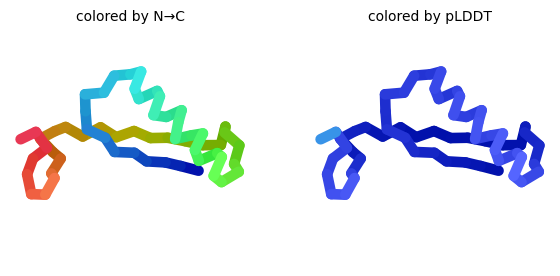

model_2_ptm_seed_0 recycles:3 tol:0.11 pLDDT:97.08 pTMscore:0.77


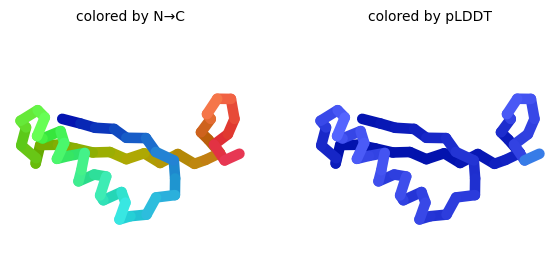

model_3_ptm_seed_0 recycles:3 tol:0.06 pLDDT:97.50 pTMscore:0.78


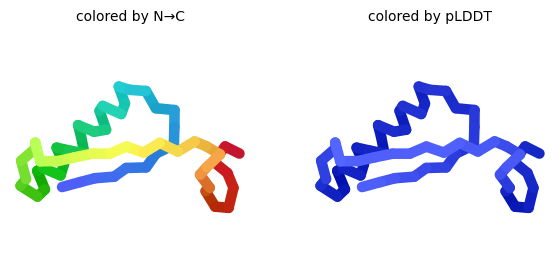

model_4_ptm_seed_0 recycles:3 tol:0.10 pLDDT:96.67 pTMscore:0.77


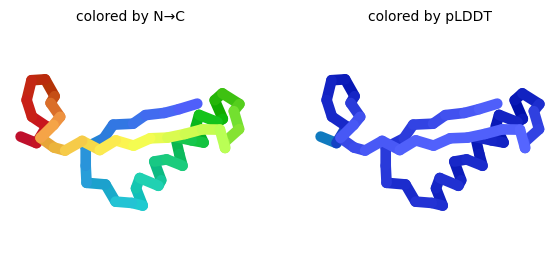

model_5_ptm_seed_0 recycles:3 tol:0.18 pLDDT:96.24 pTMscore:0.78


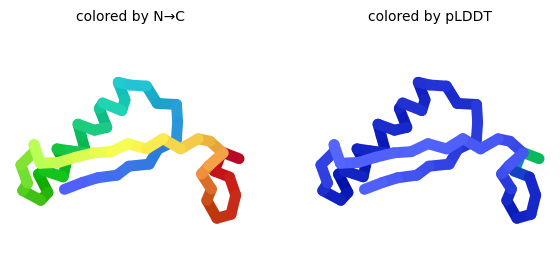

model rank based on pLDDT
rank_1_model_3_ptm_seed_0 pLDDT:97.50
rank_2_model_2_ptm_seed_0 pLDDT:97.08
rank_3_model_4_ptm_seed_0 pLDDT:96.67
rank_4_model_1_ptm_seed_0 pLDDT:96.44
rank_5_model_5_ptm_seed_0 pLDDT:96.24


In [4]:
#@title run alphafold
num_relax = "None"
rank_by = "pLDDT" #@param ["pLDDT","pTMscore"]
use_turbo = True #@param {type:"boolean"}
max_msa = "512:1024" #@param ["512:1024", "256:512", "128:256", "64:128", "32:64"]
max_msa_clusters, max_extra_msa = [int(x) for x in max_msa.split(":")]



#@markdown - `rank_by` specify metric to use for ranking models (For protein-protein complexes, we recommend pTMscore)
#@markdown - `use_turbo` introduces a few modifications (compile once, swap params, adjust max_msa) to speedup and reduce memory requirements. Disable for default behavior.
#@markdown - `max_msa` defines: `max_msa_clusters:max_extra_msa` number of sequences to use. When adjusting after GPU crash, be sure to `Runtime` → `Restart runtime`. (Lowering will reduce GPU requirements, but may result in poor model quality. This option ignored if `use_turbo` is disabled)
show_images = True #@param {type:"boolean"}
#@markdown - `show_images` To make things more exciting we show images of the predicted structures as they are being generated. (WARNING: the order of images displayed does not reflect any ranking).
#@markdown ---
#@markdown #### Sampling options
#@markdown There are two stochastic parts of the pipeline. Within the feature generation (choice of cluster centers) and within the model (dropout). 
#@markdown To get structure diversity, you can iterate through a fixed number of random_seeds (using `num_samples`) and/or enable dropout (using `is_training`).

num_models = 5 #@param [1,2,3,4,5] {type:"raw"}
use_ptm = True #@param {type:"boolean"}
num_ensemble = 1 #@param [1,8] {type:"raw"}
max_recycles = 3 #@param [1,3,6,12,24,48] {type:"raw"}
tol = 0 #@param [0,0.1,0.5,1] {type:"raw"}
is_training = False #@param {type:"boolean"}
num_samples = 1 #@param [1,2,4,8,16,32] {type:"raw"}
#@markdown - `num_models` specify how many model params to try. (5 recommended)
#@markdown - `use_ptm` uses Deepmind's `ptm` finetuned model parameters to get PAE per structure. Disable to use the original model params. (Disabling may give alternative structures.)
#@markdown - `num_ensemble` the trunk of the network is run multiple times with different random choices for the MSA cluster centers. (`1`=`default`, `8`=`casp14 setting`)
#@markdown - `max_recycles` controls the maximum number of times the structure is fed back into the neural network for refinement. (3 recommended)
#@markdown  - `tol` tolerance for deciding when to stop (CA-RMS between recycles)
#@markdown - `is_training` enables the stochastic part of the model (dropout), when coupled with `num_samples` can be used to "sample" a diverse set of structures.
#@markdown - `num_samples` number of random_seeds to try.
subsample_msa = True #@param {type:"boolean"}
#@markdown - `subsample_msa` subsample large MSA to `3E7/length` sequences to avoid crashing the preprocessing protocol.

save_pae_json = True 
save_tmp_pdb = True


if use_ptm == False and rank_by == "pTMscore":
  print("WARNING: models will be ranked by pLDDT, 'use_ptm' is needed to compute pTMscore")
  rank_by = "pLDDT"

#############################
# delete old files
#############################
for f in os.listdir(output_dir):
  if "rank_" in f:
    os.remove(os.path.join(output_dir, f))

#############################
# homooligomerize
#############################
lengths = [len(seq) for seq in seqs]
msas_mod, deletion_matrices_mod = cf.homooligomerize_heterooligomer(msas, deletion_matrices,
                                                                    lengths, homooligomers)
#############################
# define input features
#############################
def _placeholder_template_feats(num_templates_, num_res_):
  return {
      'template_aatype': np.zeros([num_templates_, num_res_, 22], np.float32),
      'template_all_atom_masks': np.zeros([num_templates_, num_res_, 37, 3], np.float32),
      'template_all_atom_positions': np.zeros([num_templates_, num_res_, 37], np.float32),
      'template_domain_names': np.zeros([num_templates_], np.float32),
      'template_sum_probs': np.zeros([num_templates_], np.float32),
  }

num_res = len(full_sequence)
feature_dict = {}
feature_dict.update(pipeline.make_sequence_features(full_sequence, 'test', num_res))
feature_dict.update(pipeline.make_msa_features(msas_mod, deletion_matrices=deletion_matrices_mod))
if not use_turbo:
  feature_dict.update(_placeholder_template_feats(0, num_res))

def do_subsample_msa(F, N=10000, random_seed=0):
  '''subsample msa to avoid running out of memory'''
  M = len(F["msa"])
  if N is not None and M > N:
    print(f"whhhaaa... too many sequences ({M}) subsampling to {N}")
    np.random.seed(random_seed)
    idx = np.append(0,np.random.permutation(np.arange(1,M)))[:N]
    F_ = {}
    F_["msa"] = F["msa"][idx]
    F_["deletion_matrix_int"] = F["deletion_matrix_int"][idx]
    F_["num_alignments"] = np.full_like(F["num_alignments"],N)
    for k in ['aatype', 'between_segment_residues',
              'domain_name', 'residue_index',
              'seq_length', 'sequence']:
              F_[k] = F[k]
    return F_
  else:
    return F

################################
# set chain breaks
################################
Ls = []
for seq,h in zip(ori_sequence.split(":"),homooligomers):
  Ls += [len(s) for s in seq.split("/")] * h

Ls_plot = sum([[len(seq)]*h for seq,h in zip(seqs,homooligomers)],[])

feature_dict['residue_index'] = cf.chain_break(feature_dict['residue_index'], Ls)

###########################
# run alphafold
###########################
def parse_results(prediction_result, processed_feature_dict):
  b_factors = prediction_result['plddt'][:,None] * prediction_result['structure_module']['final_atom_mask']  
  dist_bins = jax.numpy.append(0,prediction_result["distogram"]["bin_edges"])
  dist_mtx = dist_bins[prediction_result["distogram"]["logits"].argmax(-1)]
  contact_mtx = jax.nn.softmax(prediction_result["distogram"]["logits"])[:,:,dist_bins < 8].sum(-1)

  out = {"unrelaxed_protein": protein.from_prediction(processed_feature_dict, prediction_result, b_factors=b_factors),
         "plddt": prediction_result['plddt'],
         "pLDDT": prediction_result['plddt'].mean(),
         "dists": dist_mtx,
         "adj": contact_mtx}
  if "ptm" in prediction_result:
    out.update({"pae": prediction_result['predicted_aligned_error'],
                "pTMscore": prediction_result['ptm']})
  return out

model_names = ['model_1', 'model_2', 'model_3', 'model_4', 'model_5'][:num_models]
total = len(model_names) * num_samples
with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
  #######################################################################
  # precompile model and recompile only if length changes
  #######################################################################
  if use_turbo:
    name = "model_5_ptm" if use_ptm else "model_5"
    N = len(feature_dict["msa"])
    L = len(feature_dict["residue_index"])
    compiled = (N, L, use_ptm, max_recycles, tol, num_ensemble, max_msa, is_training)
    if "COMPILED" in dir():
      if COMPILED != compiled: recompile = True
    else: recompile = True
    if recompile:
      cf.clear_mem("gpu")
      cfg = config.model_config(name)      

      # set size of msa (to reduce memory requirements)
      msa_clusters = min(N, max_msa_clusters)
      cfg.data.eval.max_msa_clusters = msa_clusters
      cfg.data.common.max_extra_msa = max(min(N-msa_clusters,max_extra_msa),1)

      cfg.data.common.num_recycle = max_recycles
      cfg.model.num_recycle = max_recycles
      cfg.model.recycle_tol = tol
      cfg.data.eval.num_ensemble = num_ensemble

      params = data.get_model_haiku_params(name,'./alphafold/data')
      model_runner = model.RunModel(cfg, params, is_training=is_training)
      COMPILED = compiled
      recompile = False

  else:
    cf.clear_mem("gpu")
    recompile = True

  # cleanup
  if "outs" in dir(): del outs
  outs = {}
  cf.clear_mem("cpu")  

  #######################################################################
  for num, model_name in enumerate(model_names): # for each model
    name = model_name+"_ptm" if use_ptm else model_name

    # setup model and/or params
    params = data.get_model_haiku_params(name, './alphafold/data')
    if use_turbo:
      for k in model_runner.params.keys():
        model_runner.params[k] = params[k]
    else:
      cfg = config.model_config(name)
      cfg.data.common.num_recycle = cfg.model.num_recycle = max_recycles
      cfg.model.recycle_tol = tol
      cfg.data.eval.num_ensemble = num_ensemble
      model_runner = model.RunModel(cfg, params, is_training=is_training)

    for seed in range(num_samples): # for each seed
      # predict
      key = f"{name}_seed_{seed}"
      pbar.set_description(f'Running {key}')
      if subsample_msa:
        subsampled_N = int(3E7/L)
        sampled_feats_dict = do_subsample_msa(feature_dict, N=subsampled_N, random_seed=seed)    
        processed_feature_dict = model_runner.process_features(sampled_feats_dict, random_seed=seed)
      else:
        processed_feature_dict = model_runner.process_features(feature_dict, random_seed=seed)

      prediction_result, (r, t) = cf.to(model_runner.predict(processed_feature_dict, random_seed=seed),"cpu")
      outs[key] = parse_results(prediction_result, processed_feature_dict)
      
      # report
      pbar.update(n=1)
      line = f"{key} recycles:{r} tol:{t:.2f} pLDDT:{outs[key]['pLDDT']:.2f}"
      if use_ptm: line += f" pTMscore:{outs[key]['pTMscore']:.2f}"
      print(line)
      if show_images:
        fig = cf.plot_protein(outs[key]["unrelaxed_protein"], Ls=Ls_plot, dpi=100)
        plt.show()
      if save_tmp_pdb:
        tmp_pdb_path = os.path.join(output_dir,f'unranked_{key}_unrelaxed.pdb')
        pdb_lines = protein.to_pdb(outs[key]["unrelaxed_protein"])
        with open(tmp_pdb_path, 'w') as f: f.write(pdb_lines)


      # cleanup
      del processed_feature_dict, prediction_result
      if subsample_msa: del sampled_feats_dict

    if use_turbo:
      del params
    else:
      del params, model_runner, cfg
      cf.clear_mem("gpu")

  # delete old files
  for f in os.listdir(output_dir):
    if "rank" in f:
      os.remove(os.path.join(output_dir, f))

  # Find the best model according to the mean pLDDT.
  model_rank = list(outs.keys())
  model_rank = [model_rank[i] for i in np.argsort([outs[x][rank_by] for x in model_rank])[::-1]]

  # Write out the prediction
  for n,key in enumerate(model_rank):
    prefix = f"rank_{n+1}_{key}" 
    pred_output_path = os.path.join(output_dir,f'{prefix}_unrelaxed.pdb')
    fig = cf.plot_protein(outs[key]["unrelaxed_protein"], Ls=Ls_plot, dpi=200)
    plt.savefig(os.path.join(output_dir,f'{prefix}.png'), bbox_inches = 'tight')
    plt.close(fig)

    pdb_lines = protein.to_pdb(outs[key]["unrelaxed_protein"])
    with open(pred_output_path, 'w') as f:
      f.write(pdb_lines)
      
############################################################
print(f"model rank based on {rank_by}")
for n,key in enumerate(model_rank):
  print(f"rank_{n+1}_{key} {rank_by}:{outs[key][rank_by]:.2f}")
  if use_ptm and save_pae_json:
    pae = outs[key]["pae"]
    max_pae = pae.max()
    # Save pLDDT and predicted aligned error (if it exists)
    pae_output_path = os.path.join(output_dir,f'rank_{n+1}_{key}_pae.json')
    # Save predicted aligned error in the same format as the AF EMBL DB
    rounded_errors = np.round(np.asarray(pae), decimals=1)
    indices = np.indices((len(rounded_errors), len(rounded_errors))) + 1
    indices_1 = indices[0].flatten().tolist()
    indices_2 = indices[1].flatten().tolist()
    pae_data = json.dumps([{
        'residue1': indices_1,
        'residue2': indices_2,
        'distance': rounded_errors.flatten().tolist(),
        'max_predicted_aligned_error': max_pae.item()
    }],
                          indent=None,
                          separators=(',', ':'))
    with open(pae_output_path, 'w') as f:
      f.write(pae_data)

In [5]:
#@title Refine structures with Amber-Relax (Optional)
#@markdown If side-chain bond geometry is important to you, enable Amber-Relax by specifying how many top ranked structures you want relaxed. By default, we disable Amber-Relax since it barely moves the main-chain (backbone) structure and can overall double the runtime.
num_relax = "None" #@param ["None", "Top1", "Top5", "All"] {type:"string"}
if num_relax == "None":
  num_relax = 0
elif num_relax == "Top1":
  num_relax = 1
elif num_relax == "Top5":
  num_relax = 5
else:
  num_relax = len(model_names) * num_samples

#@markdown - `num_relax` specify how many of the top ranked structures to relax
if num_relax > 0 and not os.path.isfile("stereo_chemical_props.txt"):
  try:
    total = 45
    with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
      pbar.set_description(f'INSTALL AMBER')
      with io.capture_output() as captured:
        # Install OpenMM and pdbfixer.
        %shell rm -rf /opt/conda
        %shell wget -q -P /tmp \
          https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh \
            && bash /tmp/Miniconda3-latest-Linux-x86_64.sh -b -p /opt/conda \
            && rm /tmp/Miniconda3-latest-Linux-x86_64.sh
        pbar.update(4)

        PATH=%env PATH
        %env PATH=/opt/conda/bin:{PATH}
        %shell conda update -qy conda \
            && conda install -qy -c conda-forge \
              python=3.7 \
              openmm=7.5.1 \
              pdbfixer
        pbar.update(40)

        %shell wget -q -P /content \
          https://git.scicore.unibas.ch/schwede/openstructure/-/raw/7102c63615b64735c4941278d92b554ec94415f8/modules/mol/alg/src/stereo_chemical_props.txt
        pbar.update(1)
        %shell mkdir -p /content/alphafold/common
        %shell cp -f /content/stereo_chemical_props.txt /content/alphafold/common

        # Apply OpenMM patch.
        %shell pushd /opt/conda/lib/python3.7/site-packages/ && \
            patch -p0 < /content/alphafold/docker/openmm.patch && \
            popd

  except subprocess.CalledProcessError:
    print(captured)
    raise

if num_relax > 0:
  if "relax" not in dir():
    # add conda environment to path
    sys.path.append('/opt/conda/lib/python3.7/site-packages')
    
    # import libraries
    from alphafold.relax import relax
    from alphafold.relax import utils

  with tqdm.notebook.tqdm(total=num_relax, bar_format=TQDM_BAR_FORMAT) as pbar:
    pbar.set_description(f'AMBER relaxation')
    for n,key in enumerate(model_rank):
      if n < num_relax:
        prefix = f"rank_{n+1}_{key}" 
        pred_output_path = os.path.join(output_dir,f'{prefix}_relaxed.pdb')
        if not os.path.isfile(pred_output_path):
          amber_relaxer = relax.AmberRelaxation(
              max_iterations=0,
              tolerance=2.39,
              stiffness=10.0,
              exclude_residues=[],
              max_outer_iterations=20)
          relaxed_pdb_lines, _, _ = amber_relaxer.process(prot=outs[key]["unrelaxed_protein"])        
          with open(pred_output_path, 'w') as f:
            f.write(relaxed_pdb_lines)
        pbar.update(n=1)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

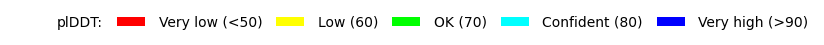

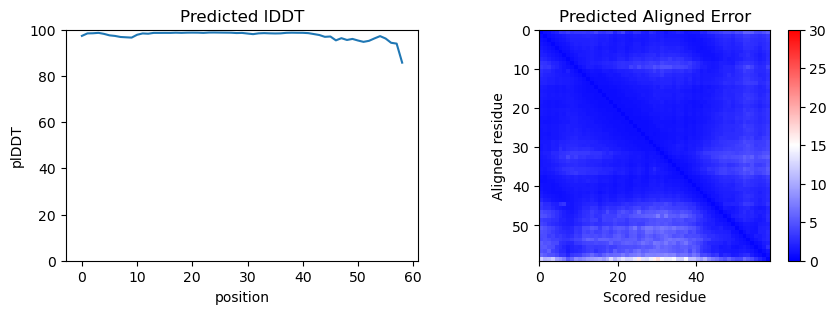

In [6]:
#@title Display 3D structure {run: "auto"}
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

key = model_rank[rank_num-1]
prefix = f"rank_{rank_num}_{key}" 
pred_output_path = os.path.join(output_dir,f'{prefix}_relaxed.pdb')  
if not os.path.isfile(pred_output_path):
  pred_output_path = os.path.join(output_dir,f'{prefix}_unrelaxed.pdb') 

cf.show_pdb(pred_output_path, show_sidechains, show_mainchains, color, Ls=Ls_plot).show()
if color == "lDDT": cf.plot_plddt_legend().show()  
if use_ptm:
  cf.plot_confidence(outs[key]["plddt"], outs[key]["pae"], Ls=Ls_plot).show()
else:
  cf.plot_confidence(outs[key]["plddt"], Ls=Ls_plot).show()

predicted alignment error


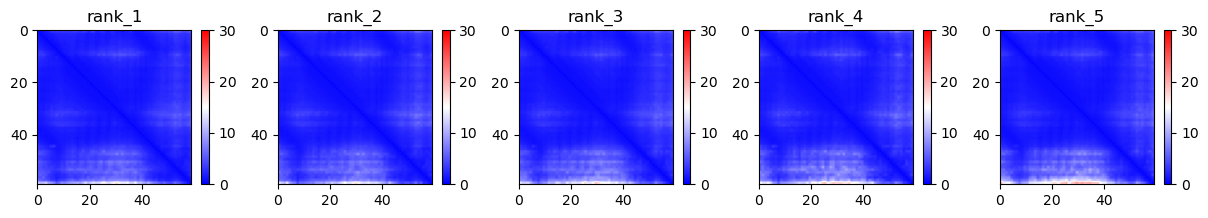

predicted contacts


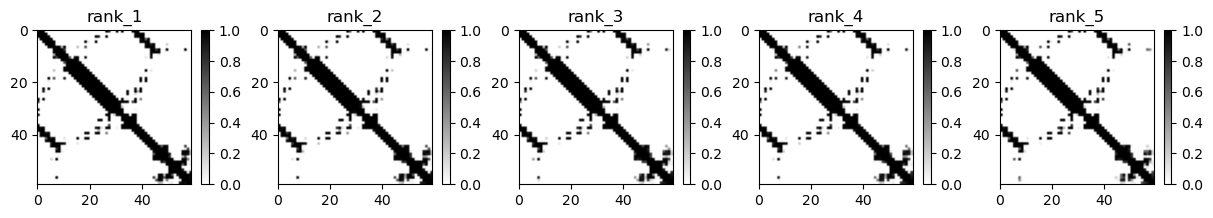

predicted distogram


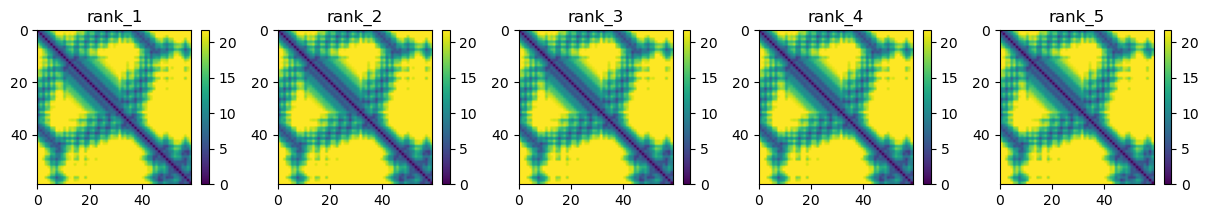

predicted LDDT


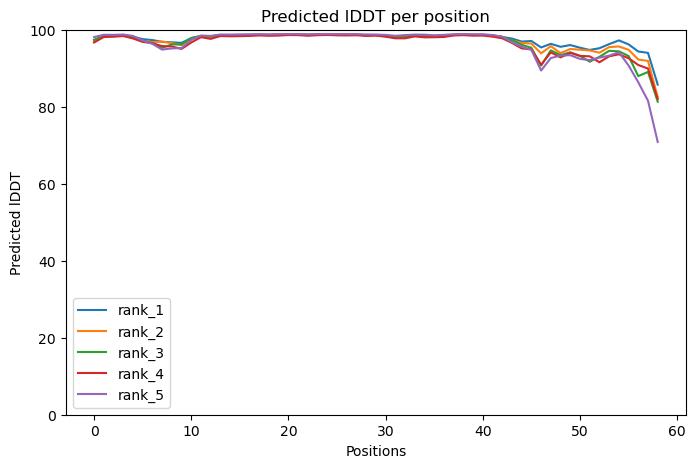

In [7]:
#@title Extra plots
dpi =  100#@param {type:"integer"}
save_to_txt = True #@param {type:"boolean"}
#@markdown - save data used to generate plots below to text file


if use_ptm:
  print("predicted alignment error")
  cf.plot_paes([outs[k]["pae"] for k in model_rank], Ls=Ls_plot, dpi=dpi)
  plt.savefig(os.path.join(output_dir,f'predicted_alignment_error.png'), bbox_inches = 'tight', dpi=np.maximum(200,dpi))
  plt.show()

print("predicted contacts")
cf.plot_adjs([outs[k]["adj"] for k in model_rank], Ls=Ls_plot, dpi=dpi)
plt.savefig(os.path.join(output_dir,f'predicted_contacts.png'), bbox_inches = 'tight', dpi=np.maximum(200,dpi))
plt.show()

print("predicted distogram")
cf.plot_dists([outs[k]["dists"] for k in model_rank], Ls=Ls_plot, dpi=dpi)
plt.savefig(os.path.join(output_dir,f'predicted_distogram.png'), bbox_inches = 'tight', dpi=np.maximum(200,dpi))
plt.show()

print("predicted LDDT")
cf.plot_plddts([outs[k]["plddt"] for k in model_rank], Ls=Ls_plot, dpi=dpi)
plt.savefig(os.path.join(output_dir,f'predicted_LDDT.png'), bbox_inches = 'tight', dpi=np.maximum(200,dpi))
plt.show()

def save_to_txt(filename, adj, dists, pae=None, Ls=None):
  adj = np.asarray(adj)
  dists = np.asarray(dists)
  if pae is not None: pae = np.asarray(pae)
  L = len(adj)
  with open(filename,"w") as out:
    header = "i\tj\taa_i\taa_j\tp(cbcb<8)\tmaxdistbin"
    header += "\tpae_ij\tpae_ji\n" if pae is not None else "\n"
    out.write(header)
    for i in range(L):
      for j in range(i+1,L):
        line = f"{i+1}\t{j+1}\t{full_sequence[i]}\t{full_sequence[j]}\t{adj[i][j]:.3f}"
        line += f"\t>{dists[i][j]:.2f}" if dists[i][j] == 21.6875 else f"\t{dists[i][j]:.2f}"
        if pae is not None: line += f"\t{pae[i][j]:.3f}\t{pae[j][i]:.3f}"
        out.write(f"{line}\n")

if save_to_txt:
  for n,k in enumerate(model_rank):
    txt_filename = os.path.join(output_dir,f'rank_{n+1}_{k}.raw.txt')
    if use_ptm:
      save_to_txt(txt_filename,adj=outs[k]["adj"],dists=outs[k]["dists"],pae=outs[k]["pae"])
    else:
      save_to_txt(txt_filename,adj=outs[k]["adj"],dists=outs[k]["dists"])

In [8]:
#@title Download prediction

#@markdown Once this cell has been executed, a zip-archive with 
#@markdown the obtained prediction will be automatically downloaded 
#@markdown to your computer.

# add settings file
settings_path = os.path.join(output_dir,"settings.txt")
with open(settings_path, "w") as text_file:
  text_file.write(f"notebook=https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/beta/AlphaFold2_advanced.ipynb\n")
  text_file.write(f"sequence={ori_sequence}\n")
  text_file.write(f"msa_method={msa_method}\n")
  if add_custom_msa:
    text_file.write(f"add_custom_msa={add_custom_msa} msa_format={msa_format}\n")
  text_file.write(f"homooligomer={homooligomer}\n")
  text_file.write(f"pair_msa={pair_msa}\n")
  if pair_msa:
    text_file.write(f"pair_cov={pair_cov}\n")
    text_file.write(f"pair_qid={pair_qid}\n")
    text_file.write(f"include_unpaired_msa={include_unpaired_msa}\n")
  text_file.write(f"max_msa={max_msa}\n")
  text_file.write(f"subsample_msa={subsample_msa}\n")  
  text_file.write(f"num_relax={num_relax}\n")
  text_file.write(f"use_turbo={use_turbo}\n")
  text_file.write(f"use_ptm={use_ptm}\n")
  text_file.write(f"rank_by={rank_by}\n")
  text_file.write(f"num_models={num_models}\n")
  text_file.write(f"num_samples={num_samples}\n")
  text_file.write(f"num_ensemble={num_ensemble}\n")
  text_file.write(f"max_recycles={max_recycles}\n")
  text_file.write(f"tol={tol}\n")
  text_file.write(f"is_training={is_training}\n")
  text_file.write(f"use_templates=False\n")
  text_file.write(f"-------------------------------------------------\n")

  for n,key in enumerate(model_rank):
    line = f"rank_{n+1}_{key} pLDDT:{outs[key]['pLDDT']:.2f}" + f" pTMscore:{outs[key]['pTMscore']:.4f}" if use_ptm else ""
    text_file.write(line+"\n")

# --- Download the predictions ---
!zip -FSr {output_dir}.zip {output_dir}
#files.download(f'{output_dir}.zip')

  adding: prediction_test_a5e17/ (stored 0%)
  adding: prediction_test_a5e17/predicted_distogram.png (deflated 13%)
  adding: prediction_test_a5e17/rank_3_model_4_ptm_seed_0_pae.json (deflated 94%)
  adding: prediction_test_a5e17/rank_3_model_4_ptm_seed_0.png (deflated 5%)
  adding: prediction_test_a5e17/predicted_alignment_error.png (deflated 14%)
  adding: prediction_test_a5e17/rank_4_model_1_ptm_seed_0_pae.json (deflated 93%)
  adding: prediction_test_a5e17/rank_2_model_2_ptm_seed_0.raw.txt (deflated 68%)
  adding: prediction_test_a5e17/settings.txt (deflated 46%)
  adding: prediction_test_a5e17/rank_4_model_1_ptm_seed_0_unrelaxed.pdb (deflated 77%)
  adding: prediction_test_a5e17/rank_1_model_3_ptm_seed_0_pae.json (deflated 94%)
  adding: prediction_test_a5e17/rank_2_model_2_ptm_seed_0_unrelaxed.pdb (deflated 77%)
  adding: prediction_test_a5e17/rank_5_model_5_ptm_seed_0_unrelaxed.pdb (deflated 77%)
  adding: prediction_test_a5e17/rank_2_model_2_ptm_seed_0.png (deflated 5%)
  addin